In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from keras.datasets import mnist
from os import listdir
import torch
import random


import tensorflow as tf
import os
import sys
import struct
import matplotlib.pyplot as plt

#Importing required libraries 
import numpy as np
import math 
import os, sys 
import shutil
import cv2
from google.colab.patches import cv2_imshow
import imutils
import pickle
import random 
import matplotlib.pyplot as plt
import string
torch.manual_seed(10)
random.seed(10)

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim

from tqdm.notebook import tqdm

import gzip


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#Preparing data

In [4]:
from torchvision.datasets import QMNIST

qtrain = QMNIST('train_qmnist', train=True, download=True) 
qtest = QMNIST('test_qmnist', what='test', download=True)


Extracting train_qmnist/QMNIST/raw/qmnist-train-images-idx3-ubyte.gz to train_qmnist/QMNIST/raw



Extracting train_qmnist/QMNIST/raw/qmnist-train-labels-idx2-int.gz to train_qmnist/QMNIST/raw


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting test_qmnist/QMNIST/raw/qmnist-test-images-idx3-ubyte.gz to test_qmnist/QMNIST/raw



Extracting test_qmnist/QMNIST/raw/qmnist-test-labels-idx2-int.gz to test_qmnist/QMNIST/raw


In [5]:

# credit: https://www.programmersought.com/article/54863640507/


def load_mnist(path, kind='train'): 
    labels_path = os.path.join(path, 
                               'qmnist-%s-labels-idx2-int' 
                               % kind) 
    images_path = os.path.join(path, 
                               'qmnist-%s-images-idx3-ubyte' 
                               % kind) 
    with open(labels_path, 'rb') as lbpath: 
        magic, n, m = struct.unpack('>III', 
                                 lbpath.read(12)) 
        labels = np.fromfile(lbpath, 
                             dtype=np.dtype('>i4')) 
  
        labels=labels.reshape(n, 8) 
        print(labels.shape) 
  
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII', 
                                               imgpath.read(16)) 
        images = np.fromfile(imgpath, 
                             dtype=np.uint8)  #np.byte=np.uint8,all of them are 8 bits 
  
        images=images.reshape(num, 784) 
        print(images.shape)
    
  
    return images, labels


In [6]:
qmnist_train=load_mnist('/content/train_qmnist/QMNIST/raw/')
x_train=qmnist_train[0]
x_train=x_train.reshape(-1,28,28)
y_train=qmnist_train[1]

qmnist_test=load_mnist('/content/test_qmnist/QMNIST/raw/',kind='test')
x_test=qmnist_test[0]
x_test=x_test.reshape(-1,28,28)
y_test=qmnist_test[1]

(60000, 8)
(60000, 784)
(60000, 8)
(60000, 784)


In [7]:
writer_ids={i:0 for i in y_train[:,2]}

for i in y_train[:,2]:
  writer_ids[i]=writer_ids[i]+1

writer_ids_list=[]
for id in writer_ids:
  writer_ids_list.append(id)

k=10
#selected_ids=random.choices(writer_ids_list,k=k)
#print(selected_ids)

selected_ids=[57,6,61,2340,188,193,102,2313,30,2130]

nums={j:{i:[] for i in range(10)} for j in selected_ids}

for i,lab in enumerate(y_train):
  if lab[2] in nums:
    the_id=lab[2]
    the_num=lab[0]
    nums[the_id][the_num].append(i)

picked_nums=nums

ids_code={selected_ids[i]:i for i in range(k)}

In [8]:
iter=0
length=[]
for id in selected_ids:
  for i in range(10):
    for the_num in picked_nums[id][i]:
      pic_name=str(iter)+'_'+str(ids_code[id])+'_'+str(i)+'.jpg'
      pic=x_train[the_num]
      
      length.append(pic_name)
      iter=iter+1
print(len(length))

1155


In [9]:
!mkdir qmnist_dataset
dataset_dir='/content/qmnist_dataset'
iter=0

for id in selected_ids:
  for i in range(10):
    for the_num in picked_nums[id][i]:
      pic_name=str(iter)+'_'+str(ids_code[id])+'_'+str(i)+'.jpg'
      pic=x_train[the_num]

      pic=Image.fromarray(pic)
      pic.save(dataset_dir+"/"+pic_name)
      iter=iter+1

In [10]:
#0 for red
#1 for green
#2 for blue
!mkdir colored
colored_dir='/content/colored'

dataset_names=listdir(dataset_dir)

for name in dataset_names:

  im=Image.open(dataset_dir+'/'+name)
  im=np.array(im)

  name=name.split('.jpg')[0]

  red_im=np.zeros((28,28,3))
  red_im[:,:,0]=im/255
  red_dir=colored_dir+'/'+str(name)+'_'+str(0)+'.jpg'
  plt.imsave(red_dir,red_im)

  green_im=np.zeros((28,28,3))
  green_im[:,:,1]=im/255
  green_dir=colored_dir+'/'+str(name)+'_'+str(1)+'.jpg'
  plt.imsave(green_dir,green_im)

  blue_im=np.zeros((28,28,3))
  blue_im[:,:,2]=im/255
  blue_dir=colored_dir+'/'+str(name)+'_'+str(2)+'.jpg'
  plt.imsave(blue_dir,blue_im)


In [11]:
#0 for 0 rotation
#1 for 90 rotation
#2 for 180 rotation
#3 for 270 rotation
!mkdir qmnist_transformed
transformed_dir='/content/qmnist_transformed'

colored_names=listdir(colored_dir)

for name in colored_names:
  im=Image.open(colored_dir+'/'+name)
  im=np.array(im)

  name=name.split('.jpg')[0]

  dir_000=transformed_dir+'/'+name+'_0.jpg'
  plt.imsave(dir_000,im)

  im90=cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
  dir_090=transformed_dir+'/'+name+'_1.jpg'
  plt.imsave(dir_090,im90)

  im180=cv2.rotate(im, cv2.ROTATE_180)
  dir_180=transformed_dir+'/'+name+'_2.jpg'
  plt.imsave(dir_180,im180)

  im270=cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
  dir_270=transformed_dir+'/'+name+'_3.jpg'
  plt.imsave(dir_270,im270)


#Loading Data

In [12]:
torch.manual_seed(10)
random.seed(10)

transformed_dir='/content/qmnist_transformed'
pic_names=listdir(transformed_dir)

test_pics=[]

for name in pic_names:
  name_s=name.split('.jpg')[0]
  name_s=name_s.split("_")
  if name_s[1]=='0':
    if name_s[2]=='0':
      if name_s[3]=='0':
        test_pics.append(name)
  if name_s[1]=='1':
    if name_s[2]=='1':
      if name_s[3]=='1':
        test_pics.append(name)
  if name_s[1]=='2':
    if name_s[2]=='6':
      if name_s[3]=='2':
        test_pics.append(name)
  if name_s[1]=='3':
    if name_s[2]=='8':
      if name_s[3]=='0':
        test_pics.append(name)
  if name_s[1]=='4':
    if name_s[2]=='9':
      if name_s[3]=='2':
        test_pics.append(name)
  if name_s[1]=='5':
    if name_s[2]=='2':
      if name_s[4]=='1':
        test_pics.append(name)
  if name_s[1]=='6':
    if name_s[2]=='3':
      if name_s[4]=='2':
        test_pics.append(name)
  if name_s[1]=='7':
    if name_s[2]=='4':
      if name_s[4]=='3':
        test_pics.append(name)
  if name_s[1]=='8':
    if name_s[2]=='5':
      if name_s[4]=='1':
        test_pics.append(name)
  if name_s[1]=='9':
    if name_s[2]=='7':
      if name_s[4]=='2':
        test_pics.append(name)

train_pics=list(set(pic_names)-set(test_pics))

random.shuffle(train_pics)

train_indices = [i for i in range(len(train_pics))]
test_indices =  [i for i in range(len(test_pics))]

partition_data = {'train' : train_indices , 
                  'test' : test_indices}
      

In [13]:
class KDEFDataset(torch.utils.data.Dataset):
  def __init__(self, indices, train=True):
    self.indices = indices
    self.train = train 

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, ind):
    if self.train:
      img_name = train_pics[ind]
      img = cv2.imread("/content/qmnist_transformed/"+ img_name)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      splitted=img_name.split('.jpg')[0]
      splitted=splitted.split('_')


      # create identity one-hot vector
      idn_one_hot = torch.zeros(10,1)
      idn_number = int(splitted[1])
      idn_one_hot[idn_number,0] = 1


      #create num one
      num_one_hot = torch.zeros(10,1)
      num_number = int(splitted[2])
      num_one_hot[num_number,0] = 1

      # create color one-hot vector
      color_one_hot = torch.zeros(3,1)
      color_number = int(splitted[3])
      color_one_hot[color_number,0] = 1

      # create transformation one-hot vector
      transform_one_hot = torch.zeros(4,1)
      transform_number = int(splitted[4])
      transform_one_hot[transform_number,0] = 1

    else:
      img_name = test_pics[ind]
      img = cv2.imread("/content/qmnist_transformed/"+img_name)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      splitted=img_name.split('.jpg')[0]
      splitted=splitted.split('_')

      # create identity one-hot vector
      idn_one_hot = torch.zeros(10,1)
      idn_number = int(splitted[1])
      idn_one_hot[idn_number,0] = 1


      #create num one
      num_one_hot = torch.zeros(10,1)
      num_number = int(splitted[2])
      num_one_hot[num_number,0] = 1

      # create color one-hot vector
      color_one_hot = torch.zeros(3,1)
      color_number = int(splitted[3])
      color_one_hot[color_number,0] = 1

      # create transformation one-hot vector
      transform_one_hot = torch.zeros(4,1)
      transform_number = int(splitted[4])
      transform_one_hot[transform_number,0] = 1 

    return torch.from_numpy(img).permute(2,0,1), idn_one_hot.squeeze(),num_one_hot.squeeze(), color_one_hot.squeeze(), transform_one_hot.squeeze()

#Network

In [14]:
class _generator(nn.Module):

    def __init__(self):
        super(_generator, self).__init__()
        
        self.lrelu = nn.LeakyReLU(0.1)
        self.relu=nn.ReLU()
        
        self.fc1_prs = nn.Linear(10, 256)
        self.fc1_num=nn.Linear(10, 256)
        self.fc1_emt = nn.Linear(3, 32)
        self.fc1_trns = nn.Linear(4, 128)

        self.fc2_prs = nn.Linear(256, 512)
        self.fc2_num = nn.Linear(256, 512)
        self.fc2_emt = nn.Linear(32, 64)
        self.fc2_trns = nn.Linear(128, 256)

        self.fc3 = nn.Linear(1344, 2048)

        self.fc4 = nn.Linear(2048, 2048)

        self.fc5 = nn.Linear(2048, 16384)

        self.uconv6 = nn.ConvTranspose2d(256, 256, 4, stride = 2, padding = 1)

        self.conv6=nn.Conv2d(256,256,3,stride=1,padding=1)

        self.uconv7 = nn.ConvTranspose2d(256, 3, 2, stride = 2, padding = 2)

        #self.uconv8 = nn.ConvTranspose2d(184, 184, 5, stride = 1, padding = 0)
        
        #self.uconv9 = nn.ConvTranspose2d(184, 3, 3, stride = 1, padding = 0)

    def forward(self,x_id, x_num, x_clr, x_trns):
        x_id = self.fc1_prs(x_id)
        x_num=self.fc1_num(x_num)
        x_clr = self.fc1_emt(x_clr)
        x_trns = self.fc1_trns(x_trns)

        x_id = self.lrelu(x_id)
        x_num = self.lrelu(x_num)
        x_clr = self.lrelu(x_clr)
        x_trns = self.lrelu(x_trns)

        x_id = self.fc2_prs(x_id)
        x_num = self.fc2_num(x_num)
        x_clr = self.fc2_emt(x_clr)
        x_trns = self.fc2_trns(x_trns)

        x = torch.cat((x_id,x_num,x_clr,x_trns), dim = 1)
        x = self.lrelu(x)

        x = self.fc3(x)
        x = self.lrelu(x)

        x = self.fc4(x)
        x = self.lrelu(x)

        x = self.fc5(x)
        x = self.lrelu(x)

        x = x.view(-1, 256, 8, 8)
        
        x = self.uconv6(x)
        x = self.lrelu(x)

        x = self.conv6(x)
        x = self.lrelu(x)

        x = self.uconv7(x)
        x = self.relu(x)
        #x = self.lrelu(x)

        #x = self.uconv8(x)
        #x = self.lrelu(x)

        #x = self.uconv9(x)
        return x 

In [15]:
class _classifier1(nn.Module):
  def __init__(self):
    super(_classifier1,self).__init__()

    self.conv1=nn.Conv2d(3,128,2,stride = 2)
    self.BN1=nn.BatchNorm2d(128)
    self.conv2=nn.Conv2d(128,256,4,stride=2,padding=2)
    self.BN2=nn.BatchNorm2d(256)

    self.lr=nn.LeakyReLU(negative_slope=0.2, inplace=True)

    layers_list=[nn.Linear(256*8*8,4096),
                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                 nn.Dropout(0.5),
                 nn.Linear(4096,1024),
                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                 nn.Dropout(0.5)]

    layers_list2=[nn.Linear(256*8*8,4096),
                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                 nn.Dropout(0.5),
                 nn.Linear(4096,4096),
                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                 nn.Dropout(0.5)]

    id_clsfr_layers=layers_list2+[nn.Linear(4096,10)]
    number_clsfr_layers=layers_list+[nn.Linear(1024,10)]
    color_clsfr_layers=layers_list+[nn.Linear(1024,3)]
    transformation_clsfr_layers=layers_list+[nn.Linear(1024,4)]

    self.flatten=nn.Flatten()

    self.id_classifier=nn.Sequential(*id_clsfr_layers)
    self.num_classifier=nn.Sequential(*number_clsfr_layers)
    self.clr_classifier=nn.Sequential(*color_clsfr_layers)
    self.tr_classifier=nn.Sequential(*transformation_clsfr_layers)

  def forward(self,x):
    x=self.BN1(self.lr(self.conv1(x)))
    x=self.BN2(self.lr(self.conv2(x)))

    x=self.flatten(x)

    the_ids=self.id_classifier(x)
    the_nums=self.num_classifier(x)
    the_colors=self.clr_classifier(x)
    transformations=self.tr_classifier(x)

    return the_ids,the_nums,the_colors,transformations



In [16]:
class GCN(nn.Module):

    def __init__(self):
        super(GCN, self).__init__()
        
        self.gen = _generator()
        self.clsf = _classifier1()

    def forward(self,x_id, x_num, x_clr, x_trns):
        img_pred = self.gen(x_id, x_num, x_clr, x_trns)
        x_id_pred,x_num_pred, x_clr_pred, x_trns_pred = self.clsf(img_pred)

        return img_pred,x_id_pred, x_num_pred, x_clr_pred, x_trns_pred

In [17]:
torch.manual_seed(10)
random.seed(10)

training_set = KDEFDataset(partition_data['train'])

training_loader = torch.utils.data.DataLoader(training_set, batch_size= 64,
                                             shuffle=True, num_workers=2)

test_set = KDEFDataset(partition_data['test'], train=False)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_pics),
                                             shuffle=True, num_workers=2)

# Hyperparameters
learning_rate = 2e-4
max_epochs = 30

# # Model
model = GCN()
model = model.to(device)

# Define Loss function and Optimizer
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate, betas=(0.9, 0.995), eps=1e-8)
scheduler = StepLR(optimizer, step_size = 30, gamma = 0.5)

train_losses = []
validation_losses = []

train_accs = []
# val_accs = []

# torch.autograd.set_detect_anomaly(True)
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_train_img,batch_train_x_id, batch_train_x_num, batch_train_x_clr, batch_train_x_trns in tqdm(training_loader):
        batch_train_img = batch_train_img.float()
        # Transfer to GPU
        batch_train_x_id=batch_train_x_id.to(device)
        batch_train_img, batch_train_x_num =  batch_train_img.to(device), batch_train_x_num.to(device)  
        batch_train_x_clr, batch_train_x_trns = batch_train_x_clr.to(device), batch_train_x_trns.to(device) 

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_img_pred, batch_train_x_id_pred,batch_train_x_num_pred, batch_train_x_clr_pred, batch_train_x_trns_pred = model(batch_train_x_id,batch_train_x_num, batch_train_x_clr, batch_train_x_trns)

        loss0 = criterion1(batch_train_x_id_pred,torch.argmax(batch_train_x_id, dim = 1))
        loss1 = criterion1(batch_train_x_num_pred,torch.argmax(batch_train_x_num, dim = 1))
        loss2 = criterion1(batch_train_x_clr_pred,torch.argmax(batch_train_x_clr, dim = 1))
        loss3 = criterion1(batch_train_x_trns_pred,torch.argmax(batch_train_x_trns, dim = 1))
        loss4 = criterion2(batch_train_img_pred,batch_train_img)

        loss = 10*loss0+10 * loss1 + 10 * loss2 + 10 * loss3 + loss4 
        loss.backward()

        # # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
        nn.utils.clip_grad_norm_(model.parameters(), max_norm= 1,error_if_nonfinite= False)

        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_x_id_pred, dim =1) == torch.argmax(batch_train_x_id, dim =1)) / batch_train_x_id.shape[0]

        if train_cnt % 35 == 34:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 35))
            running_loss = 0.0
        
        train_cnt += 1

    scheduler.step()
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
        # Validation
        #if itr % 1 == 0:
            # with torch.set_grad_enabled(False):
            #     val_cnt = 1
            #     for batch_img, batch_x_num, batch_x_clr, batch_x_trns in tqdm(validation_generator):

            #         # Transfer to GPU
            #         batch_img, batch_x_num =  batch_img.to(device), batch_x_num.to(device)  
            #         batch_x_clr, batch_x_trns = batch_x_clr.to(device), batch_x_trns.to(device) 
                    
            #         # Model computations
            #         # forward + backward + optimize
            #         batch_img_pred, batch_x_num_pred, batch_x_clr_pred, batch_x_trns_pred = model(batch_img, batch_x_num, batch_x_clr, batch_x_trns)
                    
            #         valloss1 = criterion1(batch_train_x_num_pred, batch_train_x_num)
            #         valloss2 = criterion1(batch_train_x_clr_pred, batch_train_x_clr)
            #         valloss3 = criterion1(batch_train_x_trns_pred, batch_train_x_trns)
            #         valloss4 = criterion2(batch_train_img_pred, batch_train_img)

            #         val_loss = 10 * valloss1 + 10 * valloss2 + valloss3 + valloss4
            #         val_loss.backward()

            #         valloss += val_loss.item()
            #         val_cnt += 1


Cost of Train data after 35 iterations in epoch 1 : 2257.245372
Cost of Train data after 70 iterations in epoch 1 : 1762.362901
Cost of Train data after 105 iterations in epoch 1 : 1655.582460
Cost of Train data after 140 iterations in epoch 1 : 1625.125502
Cost of Train data after 175 iterations in epoch 1 : 1601.124376
Cost of Train data after 210 iterations in epoch 1 : 1574.497032



Cost of Train data after 35 iterations in epoch 2 : 1171.318372
Cost of Train data after 70 iterations in epoch 2 : 847.950809
Cost of Train data after 105 iterations in epoch 2 : 795.835038
Cost of Train data after 140 iterations in epoch 2 : 755.599712
Cost of Train data after 175 iterations in epoch 2 : 723.090386
Cost of Train data after 210 iterations in epoch 2 : 695.294310



Cost of Train data after 35 iterations in epoch 3 : 672.499540
Cost of Train data after 70 iterations in epoch 3 : 635.970325
Cost of Train data after 105 iterations in epoch 3 : 617.884410
Cost of Train data after 140 iterations in epoch 3 : 608.639882
Cost of Train data after 175 iterations in epoch 3 : 594.713135
Cost of Train data after 210 iterations in epoch 3 : 576.083266



Cost of Train data after 35 iterations in epoch 4 : 558.282309
Cost of Train data after 70 iterations in epoch 4 : 543.935881
Cost of Train data after 105 iterations in epoch 4 : 554.221320
Cost of Train data after 140 iterations in epoch 4 : 541.284884
Cost of Train data after 175 iterations in epoch 4 : 517.256083
Cost of Train data after 210 iterations in epoch 4 : 509.750427



Cost of Train data after 35 iterations in epoch 5 : 515.890599
Cost of Train data after 70 iterations in epoch 5 : 500.893287
Cost of Train data after 105 iterations in epoch 5 : 504.255069
Cost of Train data after 140 iterations in epoch 5 : 490.851834
Cost of Train data after 175 iterations in epoch 5 : 478.295878
Cost of Train data after 210 iterations in epoch 5 : 478.852432



Cost of Train data after 35 iterations in epoch 6 : 467.666432
Cost of Train data after 70 iterations in epoch 6 : 476.455612
Cost of Train data after 105 iterations in epoch 6 : 475.204915
Cost of Train data after 140 iterations in epoch 6 : 470.212652
Cost of Train data after 175 iterations in epoch 6 : 470.470242
Cost of Train data after 210 iterations in epoch 6 : 461.065516



Cost of Train data after 35 iterations in epoch 7 : 466.413579
Cost of Train data after 70 iterations in epoch 7 : 462.866290
Cost of Train data after 105 iterations in epoch 7 : 451.906005
Cost of Train data after 140 iterations in epoch 7 : 455.997385
Cost of Train data after 175 iterations in epoch 7 : 450.708545
Cost of Train data after 210 iterations in epoch 7 : 455.276527



Cost of Train data after 35 iterations in epoch 8 : 441.040450
Cost of Train data after 70 iterations in epoch 8 : 447.847997
Cost of Train data after 105 iterations in epoch 8 : 451.444114
Cost of Train data after 140 iterations in epoch 8 : 451.003792
Cost of Train data after 175 iterations in epoch 8 : 449.165848
Cost of Train data after 210 iterations in epoch 8 : 449.708622



Cost of Train data after 35 iterations in epoch 9 : 442.084419
Cost of Train data after 70 iterations in epoch 9 : 443.849781
Cost of Train data after 105 iterations in epoch 9 : 441.843323
Cost of Train data after 140 iterations in epoch 9 : 439.821966
Cost of Train data after 175 iterations in epoch 9 : 440.298692
Cost of Train data after 210 iterations in epoch 9 : 443.893962



Cost of Train data after 35 iterations in epoch 10 : 438.036457
Cost of Train data after 70 iterations in epoch 10 : 428.649364
Cost of Train data after 105 iterations in epoch 10 : 444.412320
Cost of Train data after 140 iterations in epoch 10 : 439.585351
Cost of Train data after 175 iterations in epoch 10 : 431.218177
Cost of Train data after 210 iterations in epoch 10 : 435.581250



Cost of Train data after 35 iterations in epoch 11 : 425.359201
Cost of Train data after 70 iterations in epoch 11 : 436.079777
Cost of Train data after 105 iterations in epoch 11 : 427.994761
Cost of Train data after 140 iterations in epoch 11 : 439.191380
Cost of Train data after 175 iterations in epoch 11 : 436.075847
Cost of Train data after 210 iterations in epoch 11 : 430.365879



Cost of Train data after 35 iterations in epoch 12 : 422.984633
Cost of Train data after 70 iterations in epoch 12 : 438.581593
Cost of Train data after 105 iterations in epoch 12 : 432.591044
Cost of Train data after 140 iterations in epoch 12 : 428.798985
Cost of Train data after 175 iterations in epoch 12 : 422.518139
Cost of Train data after 210 iterations in epoch 12 : 428.811847



Cost of Train data after 35 iterations in epoch 13 : 427.719323
Cost of Train data after 70 iterations in epoch 13 : 430.148087
Cost of Train data after 105 iterations in epoch 13 : 423.505021
Cost of Train data after 140 iterations in epoch 13 : 427.650312
Cost of Train data after 175 iterations in epoch 13 : 418.387008
Cost of Train data after 210 iterations in epoch 13 : 427.270469



Cost of Train data after 35 iterations in epoch 14 : 422.509586
Cost of Train data after 70 iterations in epoch 14 : 423.026783
Cost of Train data after 105 iterations in epoch 14 : 416.431946
Cost of Train data after 140 iterations in epoch 14 : 428.177691
Cost of Train data after 175 iterations in epoch 14 : 425.099663
Cost of Train data after 210 iterations in epoch 14 : 425.981906



Cost of Train data after 35 iterations in epoch 15 : 421.077716
Cost of Train data after 70 iterations in epoch 15 : 422.224823
Cost of Train data after 105 iterations in epoch 15 : 428.573584
Cost of Train data after 140 iterations in epoch 15 : 417.136756
Cost of Train data after 175 iterations in epoch 15 : 416.365159
Cost of Train data after 210 iterations in epoch 15 : 425.470734



Cost of Train data after 35 iterations in epoch 16 : 405.265264
Cost of Train data after 70 iterations in epoch 16 : 413.003466
Cost of Train data after 105 iterations in epoch 16 : 423.900148
Cost of Train data after 140 iterations in epoch 16 : 428.967333
Cost of Train data after 175 iterations in epoch 16 : 424.331542
Cost of Train data after 210 iterations in epoch 16 : 427.520411



Cost of Train data after 35 iterations in epoch 17 : 417.196764
Cost of Train data after 70 iterations in epoch 17 : 416.987721
Cost of Train data after 105 iterations in epoch 17 : 417.452091
Cost of Train data after 140 iterations in epoch 17 : 421.050723
Cost of Train data after 175 iterations in epoch 17 : 424.138777
Cost of Train data after 210 iterations in epoch 17 : 414.549869



Cost of Train data after 35 iterations in epoch 18 : 412.334137
Cost of Train data after 70 iterations in epoch 18 : 412.702523
Cost of Train data after 105 iterations in epoch 18 : 426.371202
Cost of Train data after 140 iterations in epoch 18 : 419.898351
Cost of Train data after 175 iterations in epoch 18 : 417.581607
Cost of Train data after 210 iterations in epoch 18 : 417.446972



Cost of Train data after 35 iterations in epoch 19 : 405.156955
Cost of Train data after 70 iterations in epoch 19 : 414.756055
Cost of Train data after 105 iterations in epoch 19 : 410.076871
Cost of Train data after 140 iterations in epoch 19 : 419.648163
Cost of Train data after 175 iterations in epoch 19 : 423.014109
Cost of Train data after 210 iterations in epoch 19 : 420.990468



Cost of Train data after 35 iterations in epoch 20 : 414.128411
Cost of Train data after 70 iterations in epoch 20 : 409.897276
Cost of Train data after 105 iterations in epoch 20 : 413.672592
Cost of Train data after 140 iterations in epoch 20 : 420.378264
Cost of Train data after 175 iterations in epoch 20 : 409.776966
Cost of Train data after 210 iterations in epoch 20 : 418.777157



Cost of Train data after 35 iterations in epoch 21 : 416.953552
Cost of Train data after 70 iterations in epoch 21 : 415.627146
Cost of Train data after 105 iterations in epoch 21 : 403.423664
Cost of Train data after 140 iterations in epoch 21 : 413.119796
Cost of Train data after 175 iterations in epoch 21 : 421.596703
Cost of Train data after 210 iterations in epoch 21 : 411.143686



Cost of Train data after 35 iterations in epoch 22 : 409.102191
Cost of Train data after 70 iterations in epoch 22 : 415.725271
Cost of Train data after 105 iterations in epoch 22 : 411.000353
Cost of Train data after 140 iterations in epoch 22 : 413.268566
Cost of Train data after 175 iterations in epoch 22 : 407.812037
Cost of Train data after 210 iterations in epoch 22 : 421.910330



Cost of Train data after 35 iterations in epoch 23 : 403.738750
Cost of Train data after 70 iterations in epoch 23 : 411.123345
Cost of Train data after 105 iterations in epoch 23 : 412.414679
Cost of Train data after 140 iterations in epoch 23 : 412.336137
Cost of Train data after 175 iterations in epoch 23 : 418.850826
Cost of Train data after 210 iterations in epoch 23 : 415.928351



Cost of Train data after 35 iterations in epoch 24 : 403.585493
Cost of Train data after 70 iterations in epoch 24 : 405.646651
Cost of Train data after 105 iterations in epoch 24 : 412.033412
Cost of Train data after 140 iterations in epoch 24 : 411.075509
Cost of Train data after 175 iterations in epoch 24 : 411.102754
Cost of Train data after 210 iterations in epoch 24 : 413.395889



Cost of Train data after 35 iterations in epoch 25 : 407.376232
Cost of Train data after 70 iterations in epoch 25 : 410.081867
Cost of Train data after 105 iterations in epoch 25 : 412.294224
Cost of Train data after 140 iterations in epoch 25 : 408.386638
Cost of Train data after 175 iterations in epoch 25 : 405.279353
Cost of Train data after 210 iterations in epoch 25 : 417.266769



Cost of Train data after 35 iterations in epoch 26 : 407.447307
Cost of Train data after 70 iterations in epoch 26 : 410.025984
Cost of Train data after 105 iterations in epoch 26 : 402.216895
Cost of Train data after 140 iterations in epoch 26 : 408.810749
Cost of Train data after 175 iterations in epoch 26 : 410.504885
Cost of Train data after 210 iterations in epoch 26 : 406.887283



Cost of Train data after 35 iterations in epoch 27 : 402.981390
Cost of Train data after 70 iterations in epoch 27 : 400.571775
Cost of Train data after 105 iterations in epoch 27 : 407.503751
Cost of Train data after 140 iterations in epoch 27 : 403.200376
Cost of Train data after 175 iterations in epoch 27 : 403.399714
Cost of Train data after 210 iterations in epoch 27 : 430.053186



Cost of Train data after 35 iterations in epoch 28 : 398.762034
Cost of Train data after 70 iterations in epoch 28 : 407.524061
Cost of Train data after 105 iterations in epoch 28 : 414.388909
Cost of Train data after 140 iterations in epoch 28 : 398.931811
Cost of Train data after 175 iterations in epoch 28 : 413.778432
Cost of Train data after 210 iterations in epoch 28 : 405.106565



Cost of Train data after 35 iterations in epoch 29 : 397.634627
Cost of Train data after 70 iterations in epoch 29 : 407.628417
Cost of Train data after 105 iterations in epoch 29 : 405.535835
Cost of Train data after 140 iterations in epoch 29 : 405.185964
Cost of Train data after 175 iterations in epoch 29 : 413.152143
Cost of Train data after 210 iterations in epoch 29 : 408.660007



Cost of Train data after 35 iterations in epoch 30 : 397.143824
Cost of Train data after 70 iterations in epoch 30 : 404.000066
Cost of Train data after 105 iterations in epoch 30 : 403.561481
Cost of Train data after 140 iterations in epoch 30 : 412.784306
Cost of Train data after 175 iterations in epoch 30 : 405.410740
Cost of Train data after 210 iterations in epoch 30 : 407.319034




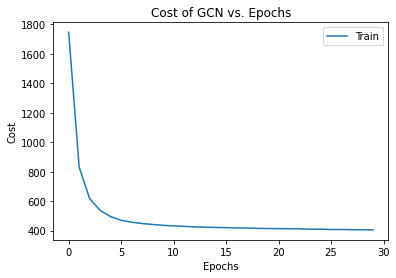

In [18]:
plt.plot(train_losses)
# plt.plot(validation_losses)
plt.title("Cost of GCN vs. Epochs")
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

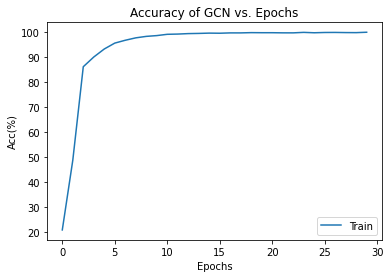

In [19]:
plt.plot(train_accs)
plt.title("Accuracy of GCN vs. Epochs")
plt.ylabel('Acc(%)')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


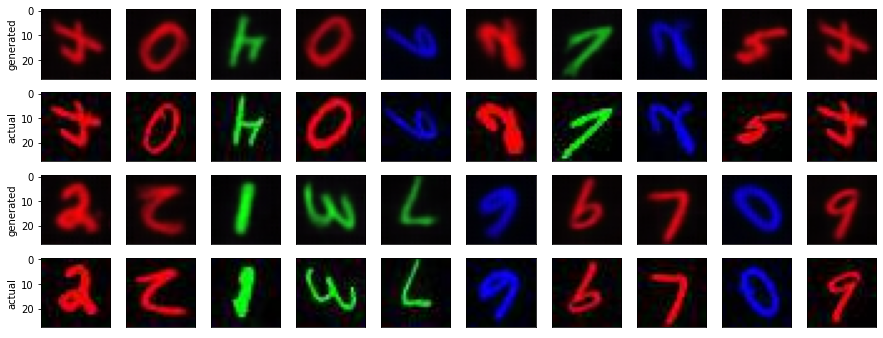

In [23]:
sam=20
tt=random.choices(list(range(batch_train_img_pred.size(0))),k=sam)
L=len(tt)
half_L=int(L/2)

plt.figure(figsize=(15,15))
i=0
for i in range(half_L):
  im=batch_train_img_pred[tt[i]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('generated')
    ax.axes.yaxis.set_visible(True)
  i=1
i=0
for i in range(half_L):
  im=batch_train_img[tt[i]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,half_L+i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('actual')
    ax.axes.yaxis.set_visible(True)
  i=1
i=0
for i in range(half_L):
  im=batch_train_img_pred[tt[i+half_L]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,2*half_L+i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('generated')
    ax.axes.yaxis.set_visible(True)
  i=1
i=0
for i in range(half_L):
  im=batch_train_img[tt[i+half_L]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,3*half_L+i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('actual')
    ax.axes.yaxis.set_visible(True)
  i=1


#Testing

In [21]:
test_set = KDEFDataset(partition_data['test'], train=False)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_pics),
                                             shuffle=True, num_workers=2)
for batch_test_img,batch_test_x_id, batch_test_x_num, batch_test_x_clr, batch_test_x_trns in tqdm(test_loader):
  batch_test_img = batch_test_img.float()
  # Transfer to GPU
  batch_test_x_id=batch_test_x_id.to(device)
  batch_test_img, batch_test_x_num =  batch_test_img.to(device), batch_test_x_num.to(device)  
  batch_test_x_clr, batch_test_x_trns = batch_test_x_clr.to(device), batch_test_x_trns.to(device) 

  # zero the parameter gradients
  optimizer.zero_grad()
  
  # Model computations
  # forward + backward + optimize
  batch_test_img_pred, batch_test_x_id_pred,batch_test_x_num_pred, batch_test_x_clr_pred, batch_test_x_trns_pred = model(batch_test_x_id,batch_test_x_num, batch_test_x_clr, batch_test_x_trns)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


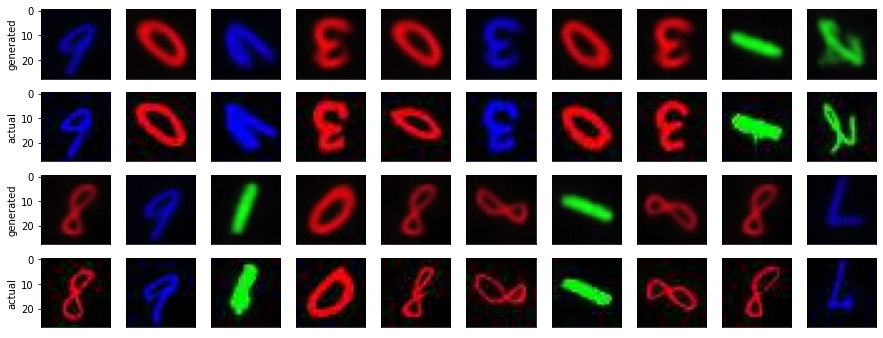

In [26]:
sam=20
tt=random.choices(list(range(batch_test_img_pred.size(0))),k=sam)
L=len(tt)
half_L=int(L/2)

plt.figure(figsize=(15,15))
i=0
for i in range(half_L):
  im=batch_test_img_pred[tt[i]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('generated')
    ax.axes.yaxis.set_visible(True)
  i=1
i=0
for i in range(half_L):
  im=batch_test_img[tt[i]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,half_L+i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('actual')
    ax.axes.yaxis.set_visible(True)
  i=1
i=0
for i in range(half_L):
  im=batch_test_img_pred[tt[i+half_L]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,2*half_L+i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('generated')
    ax.axes.yaxis.set_visible(True)
  i=1
i=0
for i in range(half_L):
  im=batch_test_img[tt[i+half_L]].permute(1,2,0).cpu().detach().numpy()
  plt.subplot(half_L,half_L,3*half_L+i+1)
  plt.imshow(im/255)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  if i==0:
    plt.ylabel('actual')
    ax.axes.yaxis.set_visible(True)
  i=1
